# Time Series Prediction


In [3]:
# @ Lukman copyright 
# MIT Licence

In [3]:
# for data frame analysis
import pandas as pd 

# for mathematical operations
import numpy as np 

# imports below are for plotly 
import ipywidgets as widgets
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)   # for offline mode use
import plotly.figure_factory as ff
import plotly.offline as offline


# matplotlib library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Normalizing data
from sklearn.preprocessing import StandardScaler

# For statistical test
import scipy.stats as stats

# Split data set into training and test set
from sklearn.model_selection import train_test_split as tts

# SVN module
from sklearn import svm

# Kernel Functions used 
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel

# module for chi square test
from scipy.stats import chisquare


# For dictionary 
from collections import defaultdict

# for use of tensorflow
import tensorflow as tf
#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *

# for scaling arrays
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler


# for random sampling of validation set
import random


import yaml
import os
from utility import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preprocessing 

In [31]:
################################################################################
# load config file
try:
    with open("../config.yml", 'r') as ymlfile:
            cfg = yaml.safe_load(ymlfile)
except (IOError):
    print('config file is required. Put config file in current directory')
################################################################################

In [5]:
# current working directory
cwd = os.getcwd()
# set the base directory. base directo
BASE_DIR = os.path.join( os.path.dirname( cwd), '' )
# cleaned data dir
cleanedpath= BASE_DIR + cfg['cleanedconfig']['cleanedDataV1']['cleanedDir'] 
# clean data Name
cleandataName = cfg['cleanedconfig']['cleanedDataV1']['cleanedName']
# traina and validation data name
trainName= cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanTrain']
validateName  = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanValidate']
validation_split = cfg['cleanedconfig']['cleanedDataV1']['validationSplit']

In [6]:
# I will Load only the zero meter data set 
# same syntax applied for other data set
meterOneDataLOaded= pd.read_csv(cleanedpath +  cleandataName )
# all meter types data set could be analysed in same manner

In [7]:
# set time stamp as index 
meterOneDataLOaded.set_index('timestamp',inplace=True);


In [9]:
y_train = meterOneDataLOaded['meter_reading']
X_train = meterOneDataLOaded.drop('meter_reading', axis=1)

In [8]:
#meterOneDataLOaded['dew_temperature'][1:2]

#### Training-Validation Spearation


In [10]:
#img_size=10;
VALIDATION_SIZE = 1000

validation_set = X_train[:VALIDATION_SIZE].values
validation_target = y_train[:VALIDATION_SIZE].values

train_set = X_train[VALIDATION_SIZE:].values
train_target = y_train[VALIDATION_SIZE:].values

print('validation-set',validation_set.shape, '|' ,'Train-set', train_set.shape)
print('------------------------------------------------')
print('validation-target',validation_target.shape,'|','Train-Target' ,train_target.shape)


validation-set (1000, 30) | Train-set (3524936, 30)
------------------------------------------------
validation-target (1000,) | Train-Target (3524936,)


In [12]:
def Standardize(array):
    '''
    Standardize an array along eachcolumn (each feature that is)
    '''
    transformer = MaxAbsScaler().fit(array)
    output = transformer.transform(array)
    return  np.array(output)

In [13]:
validation_set = Standardize(validation_set)
#validation_target = Standardize(validation_target)
train_set = Standardize(train_set)
#train_target =  Standardize(train_target)



In [14]:
#validation_set.astype(np.float64, copy=False);

In [15]:
#train_set.astype(np.float64, copy=False);

In [16]:
epochs_completed = 0
index_in_epoch = 0
num_examples = train_set.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_set
    global train_target
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        train_set = train_set[perm]
        train_target = train_target[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_set[start:end], train_target[start:end]

In [17]:
import random
def valdation_random_sampler(validation_set, validation_target, n_validation_sample):    
    rng = np.random.RandomState(42)  # reproducible results with a fixed seed
    indices = random.sample(range(0, len(validation_set)-1), n_validation_sample)
    #indices = np.arange(n_samples)
    
    rng.shuffle(indices)
    #print(indices)
    x_shuffled = validation_set[indices]
    y_shuffled = validation_target[indices]
    return x_shuffled,y_shuffled

In [18]:
#a,b= valdation_random_sampler(validation_set, validation_target,10)

### Modelling with LSTM

In [19]:
#Input Params
with tf.name_scope("input_target_placeholders"):    
    input_dim = 1
    ##The Input Layer as a Placeholder
    #Since we will provide data sequentially, the 'batch size'
    #is 1.
    input_layer = tf.placeholder(tf.float32, [1, input_dim*train_set.shape[1]],name="input_data")
    correct_output = tf.placeholder(tf.float32, [input_dim],name="target_data")

In [20]:
with tf.variable_scope("lstmLayer",reuse=tf.AUTO_REUSE ):    
    lstm_layer1 = rnn_cell.BasicLSTMCell(input_dim*2042,state_is_tuple=False)
    #lstm_layer1 = rnn_cell.BasicLSTMCell(input_dim*1,state_is_tuple=True)

    #The LSTM state as a Variable initialized to zeroes
    lstm_state1 = tf.Variable(tf.zeros([1, lstm_layer1.state_size]),trainable=False,name="initial_state")
    #lstm_state1 = tf.Variable(lstm_layer1.zero_state(1,lstm_layer1.state_size[-1] ), trainable=False)
    #Connect the input layer and initial LSTM state to the LSTM cell
    lstm_output1, lstm_state_output1 = lstm_layer1(input_layer, lstm_state1)
    #The LSTM state will get updated
    outputs = lstm_state1.assign(lstm_state_output1)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [21]:
lstm_output1

<tf.Tensor 'lstmLayer/basic_lstm_cell/Mul_2:0' shape=(1, 2042) dtype=float32>

In [22]:
lstm_output1.shape

TensorShape([Dimension(1), Dimension(2042)])

In [23]:
with tf.name_scope("weight_Bias_learning_rate"):
    global_step = tf.Variable(0, trainable=False,name="global_step")
    starter_learning_rate = 1e-6
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.8, staircase=False,name ="Exponential_decay")
    ##The Regression-Output Layer
    #The Weights and Biases matrices first
    output_W1 = tf.Variable(tf.truncated_normal([int(lstm_output1.shape[1]), 1]),name="weight")
    output_b1 = tf.Variable(tf.truncated_normal([input_dim]),name="bias")


In [24]:
with tf.name_scope("prediction"):
    #Compute the output
    final_output = tf.matmul(lstm_output1, output_W1) + output_b1

In [25]:

lambda_l2_reg=0.9
l2 = lambda_l2_reg * sum( tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "bias" in tf_var.name) )

In [26]:
bias_factor = 0.01
with tf.name_scope("RMS_error"):
    ##Calculate the Sum-of-Squares Error
    error = tf.pow(tf.subtract(final_output, correct_output), 2)+(bias_factor*l2)

In [27]:
with tf.variable_scope("optimizer",reuse=tf.AUTO_REUSE ):    
    ##The Optimizer
    #Adam works best
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(error)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
# Create a summary to monitor MSE
mse=tf.summary.tensor_summary("errors_Summary",error)
# Create a summary to monitor  predictions
prediction=tf.summary.tensor_summary("predictions_Summmary", final_output)
# Create a summary to monitor bias
bias_vec=tf.summary.tensor_summary("bias", output_b1)
# create sumary
#rate_vec=tf.summary.scalar("rate", learning_rate)


#histogram plot

error_stats=tf.summary.histogram("errors_Histogram",error)
weight_stats=tf.summary.histogram("weights_Histogram",output_W1)
bias_stats=tf.summary.histogram("biases_Histogram",output_b1)
#learning_stats=tf.histogram_summary("biases_Histogram",learning_rate)


#merged_summary_op =  tf.merge_all_summaries()
merged_summary_op =   tf.summary.merge([mse,prediction,bias_vec,error_stats,weight_stats,bias_stats])

In [39]:
##Session
sess = tf.Session()
#Initialize all Variables
sess.run(tf.global_variables_initializer())

In [34]:
# check path
checkpoint_path = cfg['savedModel']['myname']['Dir5'] 


In [35]:
checkpoint_path

'savedModels/lstmModel/'

In [36]:
# make path if not available
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [46]:
# save dir
save_dir =   checkpoint_path + cfg['savedModel']['myname']['modelName5']
# save dir 
saver = tf.train.Saver()

In [48]:
# logs_path = './lstm/'
#saver.restore(sess= sess, save_path= save_dir)


# Training

In [49]:
#tf.summary.FileWriter
train_errors = []
train_prediction = []
validation_errors = []
validation_prediction= []
display_step = 1
VALIDATON= True

n_validation_sample = 2
#writer = tf.summary.FileWriter(logs_path, graph= tf.get_default_graph())
TRAINING_ITERATIONS = 2

In [79]:

# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 5
    
DROPOUT = 0.5
#BATCH_SIZES = 200

# set to 0 to train on all available data

BATCH_SIZE= 30

In [80]:
#update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# reset global parameters before traning/running
epochs_completed = 0
index_in_epoch = 0
num_examples = train_set.shape[0]

# run training

for i in range(TRAINING_ITERATIONS):

        #get new batch
        batch_xs, batch_ys = next_batch(BATCH_SIZE)  
        
        temp = [] # store output temporally
        for m,n in zip(batch_xs,batch_ys):
            
            # check progress on every 1st,2nd,...,10th,20th,...,100th... step
            _, _, network_output,errors,summary = sess.run([outputs,
                                         train_step,
                                         final_output,error,merged_summary_op],
                                        feed_dict = {
                                            input_layer: m.reshape(1,train_set.shape[1]),
                                            correct_output: np.array([n])})
            
        
            #writer.add_summary(summary)
            #print(errors,network_output, n)
            temp.append(errors)
            train_prediction.append(network_output) # store predicted value
            
        saver.save(sess, save_dir)
        error_mean = np.mean(temp)                  
        train_errors.append(error_mean)
               
        if(VALIDATON):
            val_train, val_tar = valdation_random_sampler(validation_set, validation_target, n_validation_sample)
            temp_ = []
            for k,l in zip(val_train,val_tar):
                sess.run(lstm_state1.assign(tf.zeros([1, lstm_layer1.state_size])))

                final_outputs, val_error = sess.run([
                                          final_output, error],
                                         feed_dict = {
                                         input_layer: k.reshape(1,train_set.shape[1]),
                                         correct_output: np.array([l])})  
                
                validation_prediction.append(final_outputs)
                temp_.append(val_error)
                 
            val_error_mean = np.mean(temp_)
            validation_errors.append(val_error_mean)
                            
            if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
                print('training_mse / validation_mse => %.2f / %.2f for step %d' % 
            (error_mean, val_error_mean, i))
              
            
                
        
        # increase display_step
        
        # increase display_step                       
        if i%(display_step*30) == 0 and i:
            display_step *= 30
        
        # train on batch

training_mse / validation_mse => 20318.73 / 13336.51 for step 0
training_mse / validation_mse => 69976.79 / 4239.04 for step 1
training_mse / validation_mse => 360660.41 / 24.26 for step 2
training_mse / validation_mse => 1367688.25 / 97511.34 for step 3
training_mse / validation_mse => 333804.09 / 37045.59 for step 4


# Error Plot

In [81]:
errorplot

array([  18463.027,   18501.973,   53436.15 ,   65448.605,   60718.195,
       1139497.5  ], dtype=float32)

In [82]:
errorplot = np.array(train_errors) # make errors into arrays
errorplot.shape

(21,)

Text(0.5, 0, 'Training epoch')

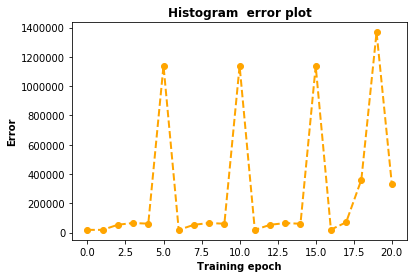

In [83]:
plt.plot(errorplot, 'o--', linewidth=2,color='orange')
plt.title("Histogram  error plot",fontweight='bold')
plt.ylabel("Error",fontweight='bold')
plt.xlabel("Training epoch",fontweight='bold')


### Test Data
No testing yet

In [ ]:
test = np.load('numpytestZero.npy')

In [ ]:
results = []
epoch= 0
max_iter = 2058086
for row in test:
        final_outputs = sess.run([ final_output],
                                         feed_dict = {
                                         input_layer: row.reshape(1,test.shape[1])})
        results.append(final_outputs)
        epoch+=1
        if epoch > max_iter:
            break
    
len(results)

In [ ]:
test = np.array(results[:])

In [ ]:
# compare plots with that below

In [ ]:
plt.plot(test.reshape(test.shape[0],1))

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


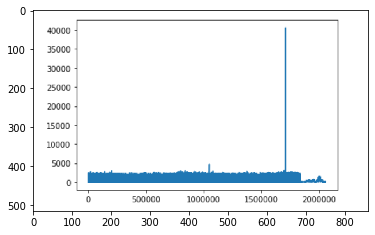

In [15]:
img  = mpimg.imread('true_plot.png')
imgplot = plt.imshow(img)
plt.show()


# Close Session

In [ ]:
sess.close()

# Preditions

# Conclusion
LSTM works fine on Time series but one needs care so that things do not blow up.
On a very suphiscated machine, this model could work impeccably well.
ARIMA,SARIMA are also very powerful models but they have less representational power compared to lstm
